In [2]:
from more_itertools import pairwise
import itertools
import igraph as ig


In [3]:
def to_stop_tuples(data_path):
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        # Skip first item, than pairwise
        for line1, line2 in pairwise(itertools.islice(lines, 1, None)):
            _, _, stop_seq1, stop_id1, _ = line1.split(';')
            _, _, stop_seq2, stop_id2, _ = line2.split(';')
            if stop_seq2 > stop_seq1:
                yield (stop_id1, stop_id2)


In [4]:
def get_stops(data_path):
    stops = dict()
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        for l in itertools.islice(lines, 1, None):  # Skip first item
            stop_id, _, stop_name, _, _, _, _, _, _ = l.split(',')
            stops[stop_id] = stop_name
    return stops

In [5]:
# Tratte data
tratte_data = '../data/processed/tratte.csv'
tratte_tuple = to_stop_tuples(tratte_data)


In [6]:
# Create graph
g = ig.Graph.TupleList(set(tratte_tuple), directed=True)
g.summary()


'IGRAPH DN-- 428 1084 -- \n+ attr: name (v)'

In [7]:
# Stops data
stops_data = '../data/original/stops.txt'
stops = get_stops(stops_data)

In [8]:
# Vertex label = stop name
g.vs['label'] = [stops[stop_id] for stop_id in g.vs['name']]


In [11]:
# Save the graph
g.write_graphml('../data/processed/trenord.graphml')

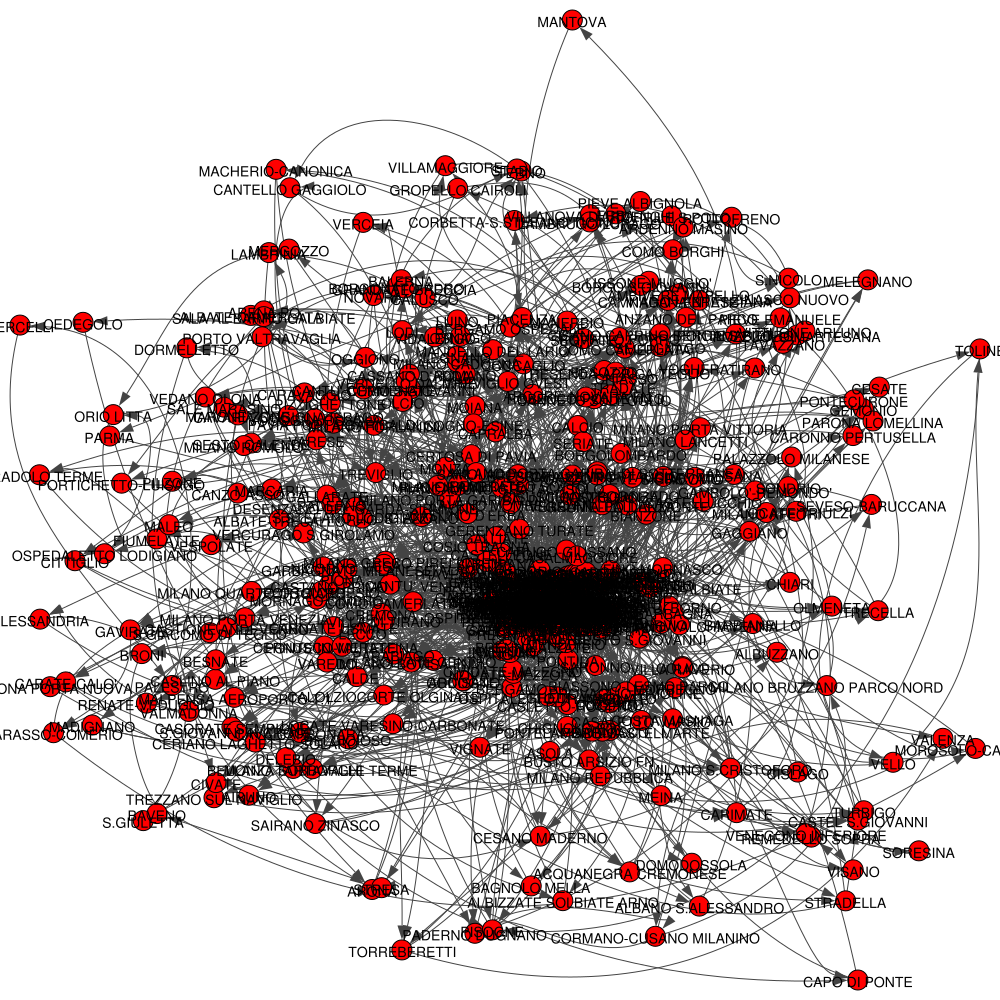

In [9]:
visual_style = {} #Python dictionary 

visual_style["vertex_label"] = g.vs["label"]
visual_style["layout"] = g.layout_kamada_kawai()
ig.plot(g, bbox=(0, 0, 1000, 1000), **visual_style) # Disabled